In [1]:
# This code works in Python 3.10.6
import os.path as osp
from typing import Dict, List, Union

import torch
import torch.nn.functional as F
from torch import nn

import torch_geometric.transforms as T
from torch_geometric.datasets import IMDB
from torch_geometric.nn import HANConv

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import networkx as nx
from collections import Counter
import random
import seaborn as sns

from torch import optim
from torch_geometric.data import HeteroData

from torch_geometric.nn import HeteroConv, Linear, SAGEConv

import warnings
warnings.filterwarnings('ignore')

Train IMDB

In [2]:
#https://github.com/pyg-team/pytorch_geometric/blob/master/examples/hetero/han_imdb.py

dataset = IMDB(root='./imdb_data')

data = dataset[0]
print(data)


class HAN(nn.Module):
    def __init__(self, in_channels: Union[int, Dict[str, int]],
                 out_channels: int, hidden_channels=128, heads=8):
        super().__init__()
        self.han_conv = HANConv(in_channels, hidden_channels, heads=heads,
                                dropout=0.6, metadata=data.metadata())
        self.lin = nn.Linear(hidden_channels, out_channels)

    def forward(self, x_dict, edge_index_dict):
        out = self.han_conv(x_dict, edge_index_dict)
        out = self.lin(out['movie'])
        return out


model = HAN(in_channels=-1, out_channels=3)
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'
data, model = data.to(device), model.to(device)

with torch.no_grad():  # Initialize lazy modules.
    out = model(data.x_dict, data.edge_index_dict)

optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=0.001)


def train() -> float:
    model.train()
    optimizer.zero_grad()
    out = model(data.x_dict, data.edge_index_dict)
    mask = data['movie'].train_mask
    loss = F.cross_entropy(out[mask], data['movie'].y[mask])
    loss.backward()
    optimizer.step()
    return float(loss)


@torch.no_grad()
def test() -> List[float]:
    model.eval()
    pred = model(data.x_dict, data.edge_index_dict).argmax(dim=-1)

    accs = []
    for split in ['train_mask', 'val_mask', 'test_mask']:
        mask = data['movie'][split]
        acc = (pred[mask] == data['movie'].y[mask]).sum() / mask.sum()
        accs.append(float(acc))
    return accs


best_val_acc = 0
start_patience = patience = 100
for epoch in range(1, 100):

    loss = train()
    train_acc, val_acc, test_acc = test()
    if epoch%10==0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train: {train_acc:.4f}, '
              f'Val: {val_acc:.4f}, Test: {test_acc:.4f}')

    if best_val_acc <= val_acc:
        patience = start_patience
        best_val_acc = val_acc
    else:
        patience -= 1

    if patience <= 0:
        print('Stopping training as validation accuracy did not improve '
              f'for {start_patience} epochs')
        break

HeteroData(
  movie={
    x=[4278, 3066],
    y=[4278],
    train_mask=[4278],
    val_mask=[4278],
    test_mask=[4278]
  },
  director={ x=[2081, 3066] },
  actor={ x=[5257, 3066] },
  (movie, to, director)={ edge_index=[2, 4278] },
  (movie, to, actor)={ edge_index=[2, 12828] },
  (director, to, movie)={ edge_index=[2, 4278] },
  (actor, to, movie)={ edge_index=[2, 12828] }
)
Epoch: 010, Loss: 0.7280, Train: 0.9075, Val: 0.5525, Test: 0.5037
Epoch: 020, Loss: 0.3187, Train: 0.9825, Val: 0.6300, Test: 0.5742
Epoch: 030, Loss: 0.2065, Train: 0.9975, Val: 0.6350, Test: 0.5653
Epoch: 040, Loss: 0.1779, Train: 1.0000, Val: 0.6200, Test: 0.5661
Epoch: 050, Loss: 0.1393, Train: 1.0000, Val: 0.6225, Test: 0.5684
Epoch: 060, Loss: 0.1320, Train: 1.0000, Val: 0.6200, Test: 0.5722
Epoch: 070, Loss: 0.1042, Train: 1.0000, Val: 0.6200, Test: 0.5687
Epoch: 080, Loss: 0.1132, Train: 1.0000, Val: 0.6125, Test: 0.5676
Epoch: 090, Loss: 0.0935, Train: 1.0000, Val: 0.6175, Test: 0.5650


Graph (without node features) generated from HGEN

In [3]:
G = nx.read_gexf("IMDB_movie_hgen.gexf")

Adding node features to graph

importing Jupyter notebook from imdb_gmm_features.ipynb
no of class movie0 node samples - 242
no of class movie1 node samples - 242
no of class movie2 node samples - 242
no of class director node samples - 410
no of class actor node samples - 494


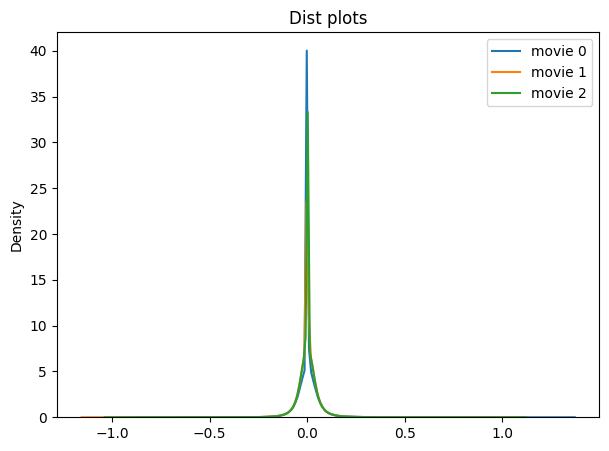

In [4]:
#Load node features 
import import_ipynb
import imdb_gmm_features

In [5]:
movie_node_features = imdb_gmm_features.movie_node_features
director_node_features = imdb_gmm_features.director_node_features
actor_node_features = imdb_gmm_features.actor_node_features

In [6]:
movie_node_features

,nodeId,0,1,2,3,4,5,6,7,8,...,3057,3058,3059,3060,3061,3062,3063,3064,3065,class
0,904,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,905,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,906,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,907,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,908,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
721,1625,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
722,1626,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
723,1627,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
724,1628,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2


In [7]:
director_node_features

,nodeId,0,1,2,3,4,5,6,7,8,...,3056,3057,3058,3059,3060,3061,3062,3063,3064,3065
0,0,-0.002757,0.010164,0.004311,0.021305,0.012218,-0.004178,-0.000550,0.010926,0.022066,...,0.029515,0.047245,-0.035171,0.006468,0.004715,0.009566,-0.000127,-0.068221,-0.004673,0.000961
1,1,0.000646,0.032546,0.001790,0.000159,-0.008500,-0.007204,0.036091,0.006662,-0.025765,...,-0.025080,0.017411,-0.053434,-0.007109,0.031613,0.012382,-0.006661,0.158823,-0.007727,0.012324
2,2,0.002747,-0.009850,0.006146,-0.034355,-0.004675,-0.003730,0.056604,0.009550,0.000445,...,-0.030213,-0.018492,0.079992,-0.027186,0.001716,0.023125,-0.010779,0.081318,0.000433,-0.004134
3,3,-0.008641,-0.003442,-0.007116,0.002731,-0.004164,0.003143,-0.003982,-0.015915,0.028118,...,-0.025814,0.027104,0.029521,0.019057,0.012483,-0.006204,-0.008701,0.050697,-0.002225,-0.003476
4,4,-0.006309,0.009009,0.002194,0.020353,-0.008426,0.002059,0.023186,-0.031230,-0.012676,...,0.023442,-0.032922,0.071591,0.003239,0.014411,-0.010064,0.003498,0.031607,-0.004503,-0.003762
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
405,405,0.003125,0.011696,-0.010214,0.009713,-0.012938,-0.001941,0.005991,-0.008482,-0.001089,...,-0.004833,0.038983,0.061414,0.008581,-0.045114,0.011286,0.006172,0.101729,-0.003784,-0.005680
406,406,-0.005101,0.000296,0.003185,0.000662,0.009546,-0.008942,-0.021314,0.001696,0.037212,...,0.011668,0.056558,0.059255,-0.032762,0.011431,0.008963,0.002739,0.072866,0.014796,-0.004611
407,407,-0.003503,-0.013595,0.017855,-0.012088,0.014189,0.009753,0.011584,0.022799,0.023870,...,-0.013700,0.048322,0.006669,-0.055296,0.004826,-0.002276,0.015490,0.128590,0.017327,0.005941
408,408,-0.004222,-0.024856,-0.019997,0.024921,0.015337,0.010159,0.005917,0.013338,0.069113,...,-0.003104,0.018944,-0.034428,0.023625,-0.056149,0.003778,0.001474,0.151136,0.013224,-0.000986


In [8]:
actor_node_features

,nodeId,0,1,2,3,4,5,6,7,8,...,3056,3057,3058,3059,3060,3061,3062,3063,3064,3065
0,410,-0.019738,0.007037,-0.041063,0.006349,0.003781,0.019081,-0.003313,-0.028191,-0.022735,...,0.017451,0.012501,0.002659,-0.013747,0.005679,-0.007995,-0.016807,-0.155896,0.000859,-0.009668
1,411,0.018394,-0.001308,0.021021,-0.012638,0.003726,0.058079,0.003104,-0.014543,-0.037013,...,0.026826,0.018168,-0.014468,-0.003089,0.009954,0.001247,0.004262,-0.093691,-0.005971,-0.051190
2,412,-0.022016,-0.050614,0.006466,-0.018942,-0.027440,0.014319,-0.008862,0.011928,-0.037594,...,-0.001115,-0.025491,-0.017222,-0.014849,0.011751,-0.057410,0.000268,0.248265,0.002084,0.008547
3,413,-0.008323,-0.043686,-0.008492,0.024046,0.008840,-0.038919,0.020235,-0.010637,0.047453,...,-0.027786,-0.015502,0.040001,0.020890,-0.015281,0.022724,0.001897,0.052227,-0.010454,0.023096
4,414,-0.027655,-0.012687,-0.016675,0.003558,-0.025939,-0.029911,0.029165,0.015828,-0.045303,...,0.026916,-0.045314,-0.015953,-0.007184,0.056829,0.013309,-0.007946,-0.007178,0.007356,0.004151
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
489,899,0.017183,0.014477,0.037979,0.002966,-0.000252,0.007878,0.016880,-0.019032,-0.002736,...,0.056764,0.041122,-0.064509,0.017776,-0.011553,-0.003436,0.001723,-0.008801,0.006458,-0.010539
490,900,0.018623,-0.002689,0.038173,-0.003963,0.015681,0.001209,-0.018090,-0.014866,0.037133,...,0.018312,-0.047826,0.054372,0.005889,-0.010637,-0.036860,0.006744,-0.095448,-0.001128,-0.023428
491,901,-0.004427,-0.030063,-0.015609,-0.018527,-0.001776,-0.013350,-0.005433,-0.010728,0.036408,...,-0.014758,0.025545,0.009672,-0.054168,-0.033361,0.063865,0.026967,0.139740,-0.002615,0.010742
492,902,0.007949,0.029290,0.009006,0.003624,0.005753,0.010977,0.015160,0.036298,0.000400,...,0.002577,0.033591,0.019959,-0.023718,-0.013187,0.030934,0.010292,0.208463,-0.000241,0.013926


In [9]:
 #Adding node degree
for node in G.nodes():
    d = G.degree(node)
    G.nodes[node]["degree"] = d

In [10]:
#Generate graphs of 2-hop neighbourhood
def graph_gen(nodeid):
    
    num_hops = 2  
    nodes = []
    edges = []
    #Get small graph nodes
    nodes = nx.single_source_shortest_path_length(G, nodeid, cutoff=num_hops).keys() 
    if 3 <= len(nodes) <= 200:
        graph = nx.ego_graph(G,nodeid, num_hops, center=True,undirected = True)
        #Get small graph edges
        edges = [e for e in graph.edges]
        #nx.draw(graph, with_labels = True)
        #plt.show()
        #print('nodeid',nodeid)
        #print('node count',len(nodes))
        #print('edge count',len(edges))
        return nodes, edges
    else:
        return None, None

In [11]:
def remap_indices(node_list):
    val_list = [*range(0, len(node_list), 1)]
    return dict(zip(node_list,val_list))  

In [12]:
def preprocess_edges(edgelist,node_list):
    res = [[node_list[i] for i, j in edgelist],[node_list[j] for i, j in edgelist]] 
    node_from = torch.tensor(res[0])
    node_to = torch.tensor(res[1])
    edges = torch.concat((node_from,node_to)).reshape(-1,len(node_from))
    return edges

In [13]:
all_edges = {}

In [14]:
def create_dataset(nodes,edges,movie_node_features,director_node_features,actor_node_features,node_id):
    
    movie_df = movie_node_features[movie_node_features["nodeId"].isin([int(x) for x in nodes])]
    director_df = director_node_features[director_node_features["nodeId"].isin([int(x) for x in nodes])]
    actor_df = actor_node_features[actor_node_features["nodeId"].isin([int(x) for x in nodes])]
    
    #Nodes   
    movie = np.asarray(movie_df.drop(columns=['nodeId','class']))
    director = np.asarray(director_df.drop(columns=['nodeId']))
    actor = np.asarray(actor_df.drop(columns=['nodeId']))
    
    x_movie = torch.tensor(movie).to(dtype=torch.float32)
    y_movie = torch.tensor(np.array(movie_df["class"]), dtype=torch.long)
    x_director = torch.tensor(director).to(dtype=torch.float32)
    x_actor = torch.tensor(actor).to(dtype=torch.float32)
    
    #Edges
    source,dest =list(map(list, zip(*edges)))
    
    movie_to_director = []
    director_to_movie = []
    movie_to_actor = []
    actor_to_movie = []
    remaining_edges = []
   
    for i in range(len(edges)):

        if (int(source[i]) in list(movie_df['nodeId'])) and (int(dest[i]) in list(director_df['nodeId'])):
            movie_to_director.append((int(source[i]),int(dest[i])))

        elif (int(source[i]) in list(movie_df['nodeId'])) and (int(dest[i]) in list(actor_df['nodeId'])):
            movie_to_actor.append((int(source[i]),int(dest[i]))) 
            
        elif (int(source[i]) in list(director_df['nodeId'])) and (int(dest[i]) in list(movie_df['nodeId'])):
            director_to_movie.append((int(source[i]),int(dest[i]))) 
            
        elif (int(source[i]) in list(actor_df['nodeId'])) and (int(dest[i]) in list(movie_df['nodeId'])):
            actor_to_movie.append((int(source[i]),int(dest[i])))

        else:
            remaining_edges.append((int(source[i]),int(dest[i])))
    
    
    all_edges[node_id] = [*movie_to_director,*movie_to_actor,*director_to_movie,*actor_to_movie]
               
    #Re-map indices to correct range
    movie_nodes_mapping = remap_indices(list(movie_df["nodeId"]))
    director_nodes_mapping = remap_indices(list(director_df["nodeId"]))
    actor_nodes_mapping = remap_indices(list(actor_df["nodeId"]))
    
    node_list = {}
    for d in [movie_nodes_mapping, director_nodes_mapping, actor_nodes_mapping]:
        node_list.update(d)
    
    #Create Hetero Data      
    small_graph = HeteroData({'movie':{'x': x_movie, 'y':y_movie}, 
                              'director':{'x': x_director},'actor':{'x': x_actor}})
    
    if movie_to_director:
        edge_index_movie_director = preprocess_edges(movie_to_director,node_list)
        small_graph['movie','to','director'].edge_index = edge_index_movie_director
        
    if director_to_movie:
        edge_index_director_movie = preprocess_edges(director_to_movie,node_list)
        small_graph['director','to','movie'].edge_index = edge_index_director_movie
    
    if actor_to_movie:
        edge_index_actor_movie = preprocess_edges(actor_to_movie,node_list)
        small_graph['actor','to','movie'].edge_index = edge_index_actor_movie
        
    if movie_to_actor:
        edge_index_movie_actor = preprocess_edges(movie_to_actor,node_list)
        small_graph['movie','to','actor'].edge_index = edge_index_movie_actor
        

    #Removing isolated nodes
    transform = T.Compose([T.remove_isolated_nodes.RemoveIsolatedNodes()])
    small_graph = transform(small_graph)
    #Adding test mask for prediction
    transform = T.RandomNodeSplit(split='train_rest', num_val=0.0, num_test=1.0)
    small_graph = transform(small_graph)
    
    return small_graph

In [15]:
def evaluate_gnn(small_graph):
    with torch.no_grad():
        model.eval()
        
        #The pred is not used for accuracy, the softmax is used
        pred = model(small_graph.x_dict, small_graph.edge_index_dict).argmax(dim=-1)
        
        #Getting class prediction probabilities from the softmax layer
        softmax = model(small_graph.x_dict, small_graph.edge_index_dict).softmax(dim=-1)
        
        mask = small_graph['movie'].test_mask
        correct = (pred[mask] == small_graph['movie'].y[mask])
               
        print(small_graph)
        print('Prediction:',pred[mask])
        print('Ground Truth:',small_graph['movie'].y[mask])
        print(correct)
        print(softmax)
        
        correct_indices = [i for i, x in enumerate(correct.tolist()) if x]
        print('correct indices',correct_indices)
        
        #Taking softmax values of the nodes for which prediction is correct
        softmax_pred_list = [softmax.tolist()[i] for i in correct_indices]
        #print(softmax_pred_list)
        print('------------------------------------------------------------------')
        
        return softmax_pred_list, correct_indices

In [16]:
node_subset = dict((n,d['degree']) for n,d in G.nodes().items() if d['degree']>=2)
n_list= random.sample(node_subset.keys(), 500)

In [17]:
softmax_dict = {}
nodefeature_dict = {}
for nodeid in n_list: 
    #Generate small Graphs
    nodes, edges = graph_gen(nodeid)
    if not (nodes is None):
        
        small_graph_data = create_dataset(nodes,edges,
                              movie_node_features,director_node_features,
                              actor_node_features,nodeid)
        
        edge_list = all_edges[nodeid]
        graph = nx.Graph(edge_list)
        if not nx.is_empty(graph) and nx.is_connected(graph):

                
            if (small_graph_data['movie'].x.nelement()!=0) and \
            (small_graph_data['actor','to','movie']) :

                print('nodeid',nodeid)
                print('node count',small_graph_data.num_nodes)
                print('edge count',small_graph_data.num_edges)

                #graph = nx.ego_graph(G,nodeid, 2, center=True,undirected = True)
                #nx.draw(graph, with_labels = True)
                #plt.show() 

                #Evaluate trained IMDB on smaller graphs

                softmax, correct_indices = evaluate_gnn(small_graph_data)
                softmax_dict[nodeid] = softmax
                nodefeature_dict[nodeid]={'movie':small_graph_data['movie'].x[correct_indices],
                                         'director':small_graph_data['director'].x,
                                         'actor':small_graph_data['actor'].x}
                #print(small_graph_data)

            else:
                #print("The next graph could not be evaluated. Required edges are missing.")
                pass

    else:
        #print("The next graph could not be loaded. Node count is less than 3")
        pass
        

nodeid 561
node count 3
edge count 2
HeteroData(
  movie={
    x=[2, 3066],
    y=[2],
    train_mask=[2],
    val_mask=[2],
    test_mask=[2]
  },
  director={ x=[0, 3066] },
  actor={ x=[1, 3066] },
  (actor, to, movie)={ edge_index=[2, 2] }
)
Prediction: tensor([1, 1])
Ground Truth: tensor([0, 1])
tensor([False,  True])
tensor([[0.2134, 0.7801, 0.0065],
        [0.2134, 0.7801, 0.0065]])
correct indices [1]
------------------------------------------------------------------
nodeid 1361
node count 2
edge count 1
HeteroData(
  movie={
    x=[1, 3066],
    y=[1],
    train_mask=[1],
    val_mask=[1],
    test_mask=[1]
  },
  director={ x=[0, 3066] },
  actor={ x=[1, 3066] },
  (actor, to, movie)={ edge_index=[2, 1] }
)
Prediction: tensor([2])
Ground Truth: tensor([1])
tensor([False])
tensor([[0.0089, 0.0046, 0.9865]])
correct indices []
------------------------------------------------------------------
nodeid 1438
node count 3
edge count 2
HeteroData(
  movie={
    x=[2, 3066],
    y=[2

nodeid 692
node count 4
edge count 3
HeteroData(
  movie={
    x=[2, 3066],
    y=[2],
    train_mask=[2],
    val_mask=[2],
    test_mask=[2]
  },
  director={ x=[1, 3066] },
  actor={ x=[1, 3066] },
  (director, to, movie)={ edge_index=[2, 1] },
  (actor, to, movie)={ edge_index=[2, 2] }
)
Prediction: tensor([2, 2])
Ground Truth: tensor([0, 1])
tensor([False, False])
tensor([[5.6364e-04, 1.2556e-02, 9.8688e-01],
        [1.2044e-01, 1.1694e-01, 7.6262e-01]])
correct indices []
------------------------------------------------------------------
nodeid 1509
node count 2
edge count 1
HeteroData(
  movie={
    x=[1, 3066],
    y=[1],
    train_mask=[1],
    val_mask=[1],
    test_mask=[1]
  },
  director={ x=[0, 3066] },
  actor={ x=[1, 3066] },
  (actor, to, movie)={ edge_index=[2, 1] }
)
Prediction: tensor([2])
Ground Truth: tensor([2])
tensor([True])
tensor([[0.1013, 0.3112, 0.5875]])
correct indices [0]
------------------------------------------------------------------
nodeid 1136
nod

nodeid 1465
node count 3
edge count 2
HeteroData(
  movie={
    x=[1, 3066],
    y=[1],
    train_mask=[1],
    val_mask=[1],
    test_mask=[1]
  },
  director={ x=[0, 3066] },
  actor={ x=[2, 3066] },
  (actor, to, movie)={ edge_index=[2, 2] }
)
Prediction: tensor([1])
Ground Truth: tensor([2])
tensor([False])
tensor([[1.9807e-04, 9.9848e-01, 1.3174e-03]])
correct indices []
------------------------------------------------------------------
nodeid 1199
node count 3
edge count 2
HeteroData(
  movie={
    x=[2, 3066],
    y=[2],
    train_mask=[2],
    val_mask=[2],
    test_mask=[2]
  },
  director={ x=[0, 3066] },
  actor={ x=[1, 3066] },
  (actor, to, movie)={ edge_index=[2, 1] },
  (movie, to, actor)={ edge_index=[2, 1] }
)
Prediction: tensor([1, 2])
Ground Truth: tensor([1, 1])
tensor([ True, False])
tensor([[2.1162e-05, 9.9913e-01, 8.4921e-04],
        [3.1340e-01, 3.0662e-01, 3.7998e-01]])
correct indices [0]
------------------------------------------------------------------
node

nodeid 1154
node count 3
edge count 2
HeteroData(
  movie={
    x=[1, 3066],
    y=[1],
    train_mask=[1],
    val_mask=[1],
    test_mask=[1]
  },
  director={ x=[0, 3066] },
  actor={ x=[2, 3066] },
  (actor, to, movie)={ edge_index=[2, 2] }
)
Prediction: tensor([1])
Ground Truth: tensor([2])
tensor([False])
tensor([[1.9807e-04, 9.9848e-01, 1.3174e-03]])
correct indices []
------------------------------------------------------------------
nodeid 508
node count 3
edge count 2
HeteroData(
  movie={
    x=[2, 3066],
    y=[2],
    train_mask=[2],
    val_mask=[2],
    test_mask=[2]
  },
  director={ x=[0, 3066] },
  actor={ x=[1, 3066] },
  (actor, to, movie)={ edge_index=[2, 2] }
)
Prediction: tensor([2, 2])
Ground Truth: tensor([1, 2])
tensor([False,  True])
tensor([[3.6847e-03, 1.0222e-04, 9.9621e-01],
        [3.6847e-03, 1.0222e-04, 9.9621e-01]])
correct indices [1]
------------------------------------------------------------------


In [18]:
print("No. of graphs evaluated: ",len(softmax_dict))

No. of graphs evaluated:  53


In [19]:
#Getting the list of predictions for each class
prob_class0_dict = {}
prob_class1_dict = {}
prob_class2_dict = {}

for nodeid in softmax_dict:
    

    if len(softmax_dict[nodeid]) > 0:
        list0= []
        list1= []
        list2= []


        for prob in softmax_dict[nodeid]:        
            list0.append(prob[0])        
            list1.append(prob[1]) 
            list2.append(prob[2]) 


     #Taking max probability of all nodes of each class in a graph
    if len(list0) != 0:
        prob_class0_dict[nodeid]=max(list0)
    if len(list1) != 0:
        prob_class1_dict[nodeid]=max(list1)
    if len(list2) != 0:
        prob_class2_dict[nodeid]=max(list2)


Getting the highest prediction probability for each class of author node

In [20]:
max_pred0 = max(prob_class0_dict.values())
max_pred1 = max(prob_class1_dict.values())
max_pred2 = max(prob_class2_dict.values())

In [21]:
# Getting nodeid to re-generate 2 hop graph which maximizes prediction
class0_nodeid = max(prob_class0_dict, key=prob_class0_dict.get)
class1_nodeid = max(prob_class1_dict, key=prob_class1_dict.get)
class2_nodeid = max(prob_class2_dict, key=prob_class2_dict.get)

In [22]:
def plot_graph(nodeid, max_pred,nodetype,edges):

    classes = []
    graph = nx.Graph(edges)
    for g in graph.nodes():
        if g in list(movie_node_features['nodeId']):
            classes.append(2)
        elif g in list(director_node_features['nodeId']):
            classes.append(0)
        elif g in list(actor_node_features['nodeId']):
            classes.append(1)
   
    
    color_class_map = {0: 'blue', 1: 'red', 2: 'darkgreen'}
    
    nx.set_node_attributes(graph, dict(zip(graph.nodes(), classes)), 'class')
    
    print('Number of nodes: ',graph.number_of_nodes())
    print('nodeid for generating 2 hop graph: ',nodeid)
    print(f'Max pred probability for class {nodetype} is {max_pred}')

    nx.draw(graph, 
    with_labels=False, node_color=[color_class_map[node[1]['class']] 
                        for node in graph.nodes(data=True)], 
        node_size=100,
        font_color='black')
    plt.show()

In [23]:
def index_2d(prob_list, v):
    for i, x in enumerate(prob_list):
        if v in x:
            return (i, x.index(v))

In [24]:
def count_plot(feat_list):
    fig, ax = plt.subplots(figsize=(7, 7))
    sns.countplot(x=0,ax=ax,data=pd.DataFrame(feat_list),width=0.3)
    for i in ax.containers:
        ax.bar_label(i,fontsize=15)
    plt.xticks(fontsize=15)

    plt.yticks(fontsize=15)
    plt.xlabel('feature values',fontsize=15)
    plt.ylabel('feature count',fontsize=15)

    plt.show()


Plotting explanation graphs and node features for each class of movie node

Node colors:

Director - Blue

Actor - Red

Movie - Darkgreen


Number of nodes:  2
nodeid for generating 2 hop graph:  1066
Max pred probability for class 0 is 0.9622601866722107


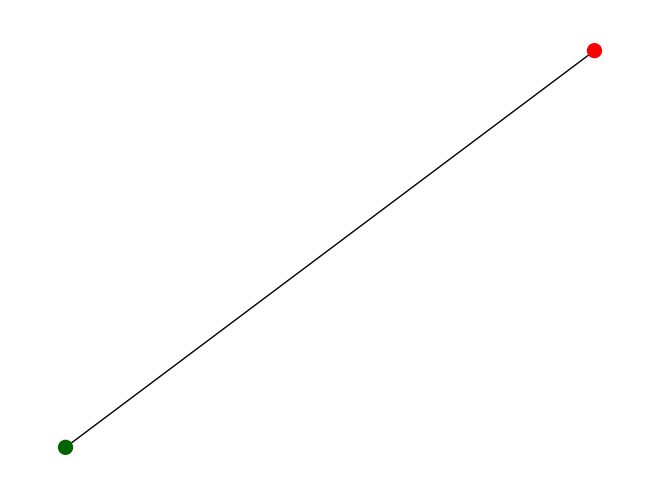

In [25]:
explanation_graph0 = plot_graph(class0_nodeid, max_pred0, 0, all_edges[class0_nodeid])

In [26]:
ind0= index_2d(softmax_dict[class0_nodeid], max_pred0)[0]

In [27]:
list0= nodefeature_dict[class0_nodeid]['movie'].numpy()[ind0]

In [28]:
Counter(list0)

Counter({0.0: 3066})

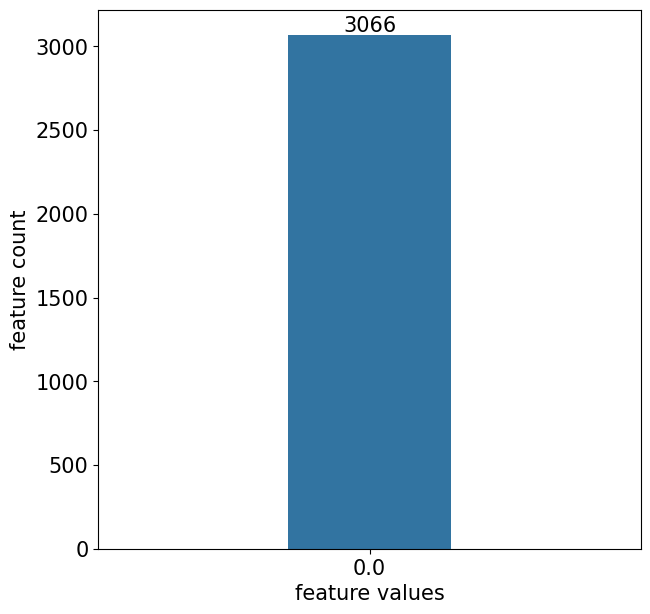

In [29]:
count_plot(list0)

Number of nodes:  4
nodeid for generating 2 hop graph:  726
Max pred probability for class 1 is 0.999129593372345


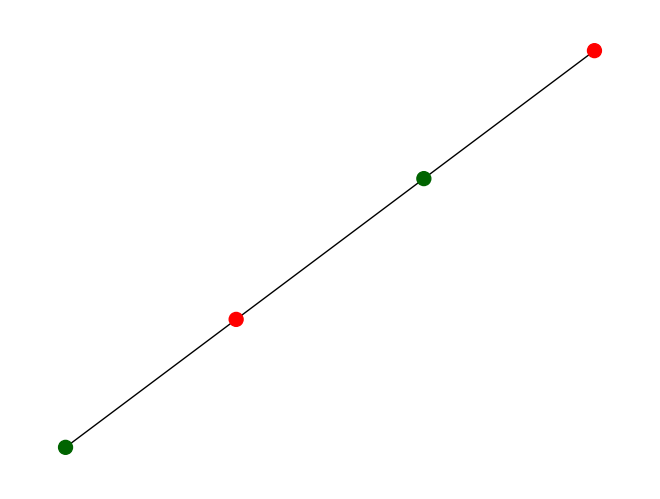

In [30]:
explanation_graph1 = plot_graph(class1_nodeid, max_pred1, 1,all_edges[class1_nodeid])

In [31]:
ind1= index_2d(softmax_dict[class1_nodeid], max_pred1)[0]

In [32]:
list1= nodefeature_dict[class1_nodeid]['movie'].numpy()[ind1]

In [33]:
Counter(list1)

Counter({0.0: 3066})

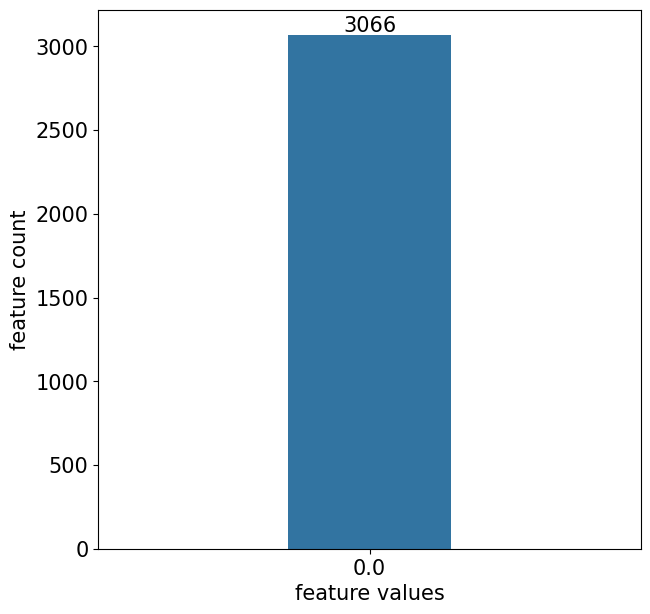

In [34]:
count_plot(list1)

Number of nodes:  3
nodeid for generating 2 hop graph:  1438
Max pred probability for class 2 is 0.9962130784988403


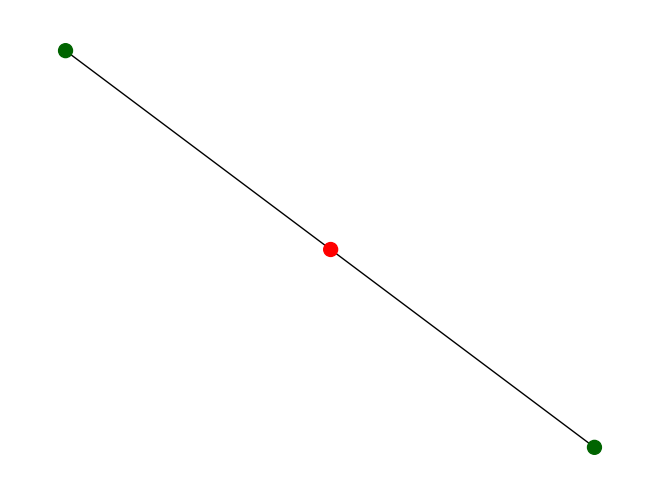

In [35]:
explanation_graph2 = plot_graph(class2_nodeid, max_pred2, 2,all_edges[class2_nodeid])

In [36]:
ind2= index_2d(softmax_dict[class2_nodeid], max_pred2)[0]

In [37]:
list2= nodefeature_dict[class2_nodeid]['movie'].numpy()[ind2]

In [38]:
Counter(list2)

Counter({0.0: 3066})

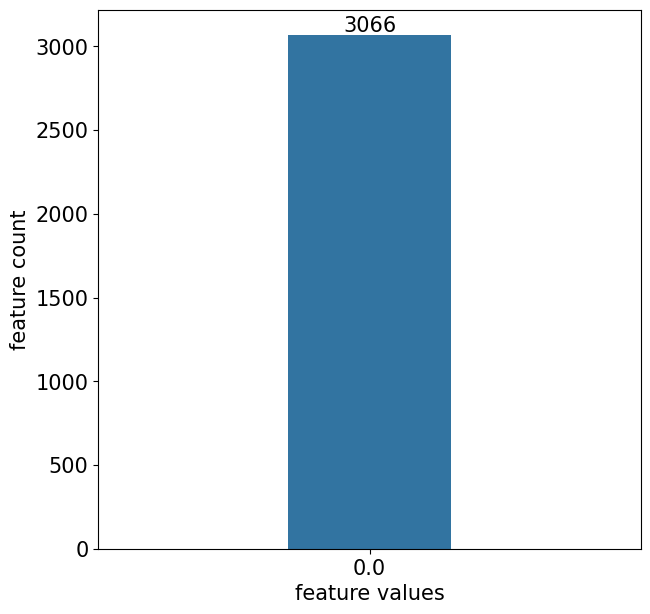

In [39]:
count_plot(list2)

In [58]:
def print_stat_cont_features(df):
    print('mean',df.stack().mean())
    print('std dev',df.stack().std())

In [47]:
def plot_node_feat(imp_feat):
    sns.distplot(imp_feat,color= 'orange',hist= False)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.ylabel('Density',fontsize=15)

    plt.show() 

In [59]:
#Actor
actor0_df = pd.DataFrame(nodefeature_dict[class0_nodeid]['actor'].numpy())
print_stat_cont_features(actor0_df)

mean 0.001609449
std dev 0.041855913


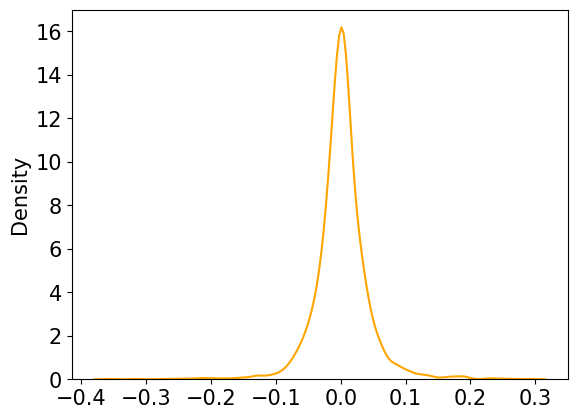

In [60]:
plot_node_feat(actor0_df)

In [61]:
actor1_df = pd.DataFrame(nodefeature_dict[class1_nodeid]['actor'].numpy())
print_stat_cont_features(actor1_df)

mean 0.0013949699
std dev 0.042558115


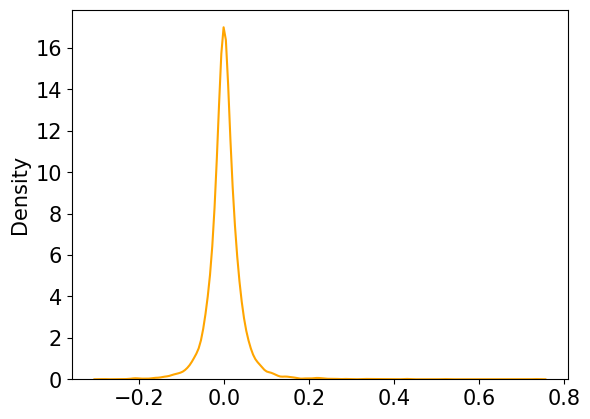

In [62]:
plot_node_feat(actor1_df)

In [63]:
actor2_df = pd.DataFrame(nodefeature_dict[class2_nodeid]['actor'].numpy())
print_stat_cont_features(actor2_df)

mean 0.0021202567
std dev 0.042595834


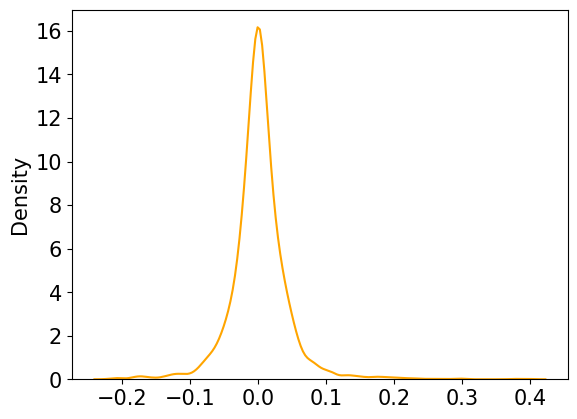

In [64]:
plot_node_feat(actor2_df)